## **Environment**

In [2]:
!pip install einops

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import einops
from einops import rearrange, reduce, repeat
from tqdm import tqdm
import imageio
import os
from PIL import Image
from torch.utils.data import DataLoader


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Utils**

In [40]:

def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

def volume_renderer (model , rays_o, rays_d, near , far , bins = 100 ):
  """
  Args:
      rays_o: (H*W, 3)
      rays_d: (H*W, 3)
      model:
  ""
  Returns:
      color (H*W, 3)
  """
  device = rays_o.device
    # r = td + o  compute t
  t  =  repeat((torch.linspace(near, far, bins , device = device) ), 'b -> r b' ,r = rays_o.shape[0]) #[rays , bins ]


  t_diff = t[:, 1:] - t[:, :-1]
  infinity_tensor = repeat(torch.tensor([1e10], device=device), '() -> r 1 ', r=rays_o.shape[0])
  delta = torch.cat((t_diff, infinity_tensor), dim=-1)

  #TODO add random sampling over each bin interval

  #r = [rays , 3] * [rays, bins] + [rays,3 ]
  r = rays_o[:, None, :] + t[:, :, None] * rays_d[:, None,: ] # [rays , bins , 3 ]


  c , sigma = model.intersect( rearrange(r , 'r b c -> (r b) c ') ,
                             rearrange(repeat((rays_d) , 'r c -> r b c ' , b = bins) , 'r b c -> (r b) c') ) #[rays * bins , c ]


  alpha = 1 - torch.exp(-rearrange(sigma , '(r b) 1 -> r (b 1)' , b = bins )*delta) # [rays , bins ]


  T = compute_accumulated_transmittance(1 - alpha)
  W = T.unsqueeze(2) * alpha.unsqueeze(2)
  c_hat = (W*rearrange(c , '(r b) c -> r b c' , b = bins)).sum(dim =1)
  weight_sum = W.sum(-1).sum(-1)  # Regularization for white background
  return c_hat+ 1 - weight_sum.unsqueeze(-1)


In [37]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

def render_rays(nerf_model, ray_origins, ray_directions, near=0, far=0.5, bins=192):
    device = ray_origins.device
    t = torch.linspace(near, far, bins, device=device).expand(ray_origins.shape[0], bins)
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor(
        [1e10], device=device).expand(ray_origins.shape[0], 1)), -1)

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(bins, ray_directions.shape[0], 3).transpose(0, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    alpha = 1 - torch.exp(-sigma.reshape(x.shape[:-1]) * delta)  # [batch_size, bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    c = (weights * colors.reshape(x.shape)).sum(dim=1)
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)

In [4]:
def get_rays(datapath, mode='train'):

    pose_file_names = [f for f in os.listdir(datapath + f'/{mode}/pose') if f.endswith('.txt')]
    intrisics_file_names = [f for f in os.listdir(datapath + f'/{mode}/intrinsics') if f.endswith('.txt')]
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f'/{mode}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f'/{mode}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4: #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3))
    rays_d = np.zeros((N, H*W, 3))
    target_px_values = images.reshape((N, H*W, 3))

    for i in range(N):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), - np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values


In [5]:
def trilinear_interpolation(res, grid, points, grid_type):
    """
    Performs trilinear interpolation of points with respect to a grid.

    Parameters:
        res (int): Resolution of the grid in each dimension.
        grid (torch.Tensor): A 3D torch tensor representing the grid.
        points (torch.Tensor): A 2D torch tensor of shape (n, 3) representing
            the points to interpolate.
        grid_type (str): Type of grid.

    Returns:
        torch.Tensor: A 1D torch tensor of shape (n,) representing the interpolated
            values at the given points.
    """
    PRIMES = [1, 265443567, 805459861]

    # Get the dimensions of the grid
    grid_size, feat_size = grid.shape
    points = points.unsqueeze(0)
    _, N, _ = points.shape

    # Get the x, y, and z coordinates of the eight nearest points for each input point
    x = points[:, :, 0] * (res - 1)
    y = points[:, :, 1] * (res - 1)
    z = points[:, :, 2] * (res - 1)

    x1 = torch.floor(torch.clip(x, 0, res - 1 - 1e-5)).int()
    y1 = torch.floor(torch.clip(y, 0, res - 1 - 1e-5)).int()
    z1 = torch.floor(torch.clip(z, 0, res - 1 - 1e-5)).int()

    x2 = torch.clip(x1 + 1, 0, res - 1).int()
    y2 = torch.clip(y1 + 1, 0, res - 1).int()
    z2 = torch.clip(z1 + 1, 0, res - 1).int()

    # Compute the weights for each of the eight points
    w1 = (x2 - x) * (y2 - y) * (z2 - z)
    w2 = (x - x1) * (y2 - y) * (z2 - z)
    w3 = (x2 - x) * (y - y1) * (z2 - z)
    w4 = (x - x1) * (y - y1) * (z2 - z)
    w5 = (x2 - x) * (y2 - y) * (z - z1)
    w6 = (x - x1) * (y2 - y) * (z - z1)
    w7 = (x2 - x) * (y - y1) * (z - z1)
    w8 = (x - x1) * (y - y1) * (z - z1)

    if grid_type == "NGLOD":
        # Interpolate the values for each point
        id1 = (x1 + y1 * res + z1 * res * res).long()
        id2 = (x2 + y1 * res + z1 * res * res).long()
        id3 = (x1 + y2 * res + z1 * res * res).long()
        id4 = (x2 + y2 * res + z1 * res * res).long()
        id5 = (x1 + y1 * res + z2 * res * res).long()
        id6 = (x2 + y1 * res + z2 * res * res).long()
        id7 = (x1 + y2 * res + z2 * res * res).long()
        id8 = (x2 + y2 * res + z2 * res * res).long()

    elif grid_type == "HASH":
        npts = res**3
        if npts > grid_size:
            id1 = ((x1 * PRIMES[0]) ^ (y1 * PRIMES[1]) ^ (z1 * PRIMES[2])) % grid_size
            id2 = ((x2 * PRIMES[0]) ^ (y1 * PRIMES[1]) ^ (z1 * PRIMES[2])) % grid_size
            id3 = ((x1 * PRIMES[0]) ^ (y2 * PRIMES[1]) ^ (z1 * PRIMES[2])) % grid_size
            id4 = ((x2 * PRIMES[0]) ^ (y2 * PRIMES[1]) ^ (z1 * PRIMES[2])) % grid_size
            id5 = ((x1 * PRIMES[0]) ^ (y1 * PRIMES[1]) ^ (z2 * PRIMES[2])) % grid_size
            id6 = ((x2 * PRIMES[0]) ^ (y1 * PRIMES[1]) ^ (z2 * PRIMES[2])) % grid_size
            id7 = ((x1 * PRIMES[0]) ^ (y2 * PRIMES[1]) ^ (z2 * PRIMES[2])) % grid_size
            id8 = ((x2 * PRIMES[0]) ^ (y2 * PRIMES[1]) ^ (z2 * PRIMES[2])) % grid_size
        else:
            id1 = (x1 + y1 * res + z1 * res * res).long()
            id2 = (x2 + y1 * res + z1 * res * res).long()
            id3 = (x1 + y2 * res + z1 * res * res).long()
            id4 = (x2 + y2 * res + z1 * res * res).long()
            id5 = (x1 + y1 * res + z2 * res * res).long()
            id6 = (x2 + y1 * res + z2 * res * res).long()
            id7 = (x1 + y2 * res + z2 * res * res).long()
            id8 = (x2 + y2 * res + z2 * res * res).long()
    else:
        print("NOT IMPLEMENTED")

    values = (
        torch.einsum("ab,abc->abc", w1, grid[(id1).long()])
        + torch.einsum("ab,abc->abc", w2, grid[(id2).long()])
        + torch.einsum("ab,abc->abc", w3, grid[(id3).long()])
        + torch.einsum("ab,abc->abc", w4, grid[(id4).long()])
        + torch.einsum("ab,abc->abc", w5, grid[(id5).long()])
        + torch.einsum("ab,abc->abc", w6, grid[(id6).long()])
        + torch.einsum("ab,abc->abc", w7, grid[(id7).long()])
        + torch.einsum("ab,abc->abc", w8, grid[(id8).long()])
    )
    return values[0]

In [6]:
def mse(prediction, target):
    return ((prediction - target) ** 2).mean()

def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))

In [7]:
def pose_spherical(theta, radius):
    trans_t = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ], dtype=np.float32)

    rot_theta = np.array([
        [np.cos(np.radians(theta)), -np.sin(np.radians(theta)), 0, 0],
        [np.sin(np.radians(theta)), np.cos(np.radians(theta)), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ], dtype=np.float32)

    c2w = trans_t @ rot_theta

    return c2w

### BaseLine Models :

[PSNR , TraningTime  ]


1.   Voxels (Done)
2.   MLP (To Do)
3.   MLP (To Do)
4.   Hyprid (Grids) Done
5.   Hyprid (Hash) To do
6.   Hyprid  (Grids + PE) Done
7.   Hyprid  (Hash + PE) To Do

In [43]:
class Plenoxels(torch.nn.Module):

    def __init__(self, LODS, L, scene_scale, desc=2):
        super(Plenoxels, self).__init__()
        self.desc = desc
        self.L = L  # For PE encoding
        self.scene_scale = scene_scale
        self.codebook = nn.ParameterList([])
        self.LODS = LODS
        print(self.LODS)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.init_feature_structure()

    def init_feature_structure(self):
      for LOD in self.LODS:
          fts = torch.zeros(LOD**3, self.desc)
          fts += torch.randn_like(fts) * 0.01
          fts = nn.Parameter(fts)
          self.codebook.append(fts)
          self.codebook = self.codebook.to(device = self.device)

    def forward(self, pts, d):

        pts /= self.scene_scale
        mask = (pts[:, 0].abs() < .5) & (pts[:, 1].abs() < .5) & (pts[:, 2].abs() < .5)
        pts += 0.5  # x in [0, 1]^3
        feats = []
        for i, res in enumerate(self.LODS):
          features = trilinear_interpolation(res, self.codebook[i], pts[mask], "NGLOD")
          feats.append((torch.unsqueeze(features, dim=-1)))
        all_features = torch.cat(feats, -1)
        all_features = all_features.sum(-1)

        color = torch.zeros((pts.shape[0], 3), device=pts.device)
        log_sigma = torch.zeros((pts.shape[0]), device=pts.device) - 100000
        color[mask] = features[:, 0:3]
        log_sigma[mask] = features[:, -1]
        return color, torch.exp(log_sigma).unsqueeze(-1)
    def intersect(self, ray_origins, ray_directions):
      return self.forward(ray_origins, ray_directions)

In [84]:
class NGLOD(torch.nn.Module):

    def __init__(self, LODS, L, scene_scale, desc=2):
        super(NGLOD, self).__init__()
        self.device = self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.desc = desc
        self.L = L  # For encoding directions
        self.scene_scale = scene_scale
        self.codebook = nn.ParameterList([])
        self.LODS = LODS
        print(self.LODS)
        self.init_feature_structure()
        self.sigma_mlp = nn.Sequential(nn.Linear(self.desc * len(Nl), 64),
                                         nn.ReLU(), nn.Linear(64, 16)).to(self.device)

        self.pred_color_mlp = nn.Sequential(nn.Linear((L-1)**3 + 16, 64), nn.ReLU(),
                                       nn.Linear(64, 64), nn.ReLU(),
                                       nn.Linear(64, 3), nn.Sigmoid()).to(self.device)
    def positional_encoding(self, x):
        out = [x]
        for j in range(self.L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)



    def init_feature_structure(self):
      for LOD in self.LODS:
          fts = torch.zeros(LOD**3, self.desc)
          fts += torch.randn_like(fts) * 0.01
          fts = nn.Parameter(fts)
          self.codebook.append(fts)
          self.codebook = self.codebook.to(device = self.device)

    def forward(self, pts, d):

        pts /= self.scene_scale
        mask = (pts[:, 0].abs() < .5) & (pts[:, 1].abs() < .5) & (pts[:, 2].abs() < .5)
        pts += 0.5  # x in [0, 1]^3
        feats = []
        for i, res in enumerate(self.LODS):
          features = trilinear_interpolation(res, self.codebook[i], pts[mask], "NGLOD")
          feats.append((torch.unsqueeze(features, dim=-1)))
        all_features = torch.cat(feats, -1)
        all_features = all_features.reshape(-1, self.desc * len(self.LODS))
        embdeded_dics = self.positional_encoding(d[mask])
        h = self.sigma_mlp(all_features)
        color = torch.zeros((pts.shape[0], 3), device=pts.device)
        log_sigma = torch.zeros((pts.shape[0]), device=pts.device) - 100000
        log_sigma[mask] = h[:, 0]
        color[mask] = self.pred_color_mlp(torch.cat((h, embdeded_dics), dim=1))
        return color, torch.exp(log_sigma).unsqueeze(-1)
    def intersect(self, ray_origins, ray_directions):
      return self.forward(ray_origins, ray_directions)

## **Eval**

In [23]:
@torch.no_grad()
def test(model, o, d, near, far, nb_bins=100, chunk_size=20, H=400, W=400, target=None):

    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)

    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = volume_renderer(model, o_batch, d_batch, near, far, bins=nb_bins)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()
    # Clip the values of the image
    image = np.clip(image, 0., 1.)
    if target is not None:
        loss = mse(image, target)
        psnr = mse2psnr(loss)

    if target is not None:
        return image,mse, psnr
    else:
        return image

In [88]:


def eval(model , test_o , test_d , H=400, W=400 , near = 8 , far = 12 ) :

  frames = []

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  for theta in range(0, 360, 5):  # Increment by 5 degrees for smoother animation
      c2w = pose_spherical(theta, 0.0)

      rays_o_rot = (c2w[:3, :3] @ test_o.T).T + c2w[:3, 3]
      rays_d_rot = (c2w[:3, :3] @ test_d.T).T

      with torch.no_grad():
          model.eval()
          img = test(model, torch.from_numpy(rays_o_rot).to(model.device).float(),
                    torch.from_numpy(rays_d_rot).to(model.device).float(), near = near , far = far)

      # Convert to uint8 image format
      img = (img.clip(0, 1) * 255).astype(np.uint8)
      frames.append(img)
      #plt.imshow(img)
      #plt.show()
  # Save frames to a video
  video_path = 'novel_views360.mp4'
  imageio.mimsave(video_path, frames, fps=20)

  print(f"Video saved to {video_path}")

## **Training**

In [24]:
class NerfTrainRunner:
    def __init__(self, model, optimizer, scheduler, near, far, nb_bins, max_epoches, data_loader, test_o,test_d ,test_target , batch_size ,checkpoints_path, loss_fn = mse ):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.near = near
        self.far = far
        self.nb_bins = nb_bins
        self.max_epoches = max_epoches
        self.data_loader = data_loader
        self.checkpoints_path = checkpoints_path
        self.training_loss = []
        self.loss_fn = loss_fn
        self.batch_size = batch_size
        self.test_o = test_o
        self.test_d = test_d
        self.test_target = test_target
        self.psnrs = []
        self.iternums = []


    def training_step(self, batch):
        o = batch[:, :3].to(self.device)
        d = batch[:, 3:6].to(self.device)
        target = batch[:, 6:].to(self.device)
        prediction = volume_renderer(self.model, o, d, self.near, self.far, bins=self.nb_bins)
        loss = mse(prediction, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.training_loss.append(loss.item())

    def train(self):

        num_batches = len(self.data_loader)
        interval = num_batches // 10  # Calculate the interval for 25%

        for epoch in range(self.max_epoches):
            for i, batch in enumerate(tqdm(self.data_loader), start=1):
                loss = self.training_step(batch)
                if i % interval == 0:
                  with torch.no_grad():
                    img, mse, psnr = test(self.model, torch.from_numpy(self.test_o).to(self.device).float(),
                    torch.from_numpy(self.test_d).to(self.device).float(), near = self.near , far = self.far ,target=self.test_target.reshape(400, 400, 3))
                    self.iternums.append(i)
                    self.psnrs.append(psnr)
                    self.plot_training_progress(img, i )
                #self.save_checkpoint(i)
            self.scheduler.step()

            # Render the holdout view for logging



            # End of logging section

        return self.training_loss


    def save_checkpoint(self, epoch):
        # Save the entire model
        checkpoint_path = os.path.join(self.checkpoints_path, f'model_nerf_epoch_{epoch}.pth')
        torch.save(self.model.cpu(), checkpoint_path)
        self.model.to(self.device)

        # Save the model state dictionary and other relevant information
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": self.model.state_dict(),
            },
            os.path.join(self.checkpoints_path, self.model_params_subdir, "latest.pth")
        )

    def plot_loss(self):
            plt.figure(figsize=(10, 5))
            plt.plot(self.training_loss, label='Training Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training Loss over Time')
            plt.legend()
            plt.show()

    def plot_training_progress( self , rgb, iteration):
      """
      Plots the training progress showing the RGB image and PSNR values.

      Args:
          rgb (np.ndarray): The RGB image to display.
          iteration (int): The current iteration number.
          iternums (list[int]): List of iteration numbers for PSNR plotting.
          psnrs (list[float]): List of PSNR values corresponding to the iterations.
      """
      plt.figure(figsize=(10, 4))

      # Plot the RGB image
      plt.subplot(121)
      plt.imshow(rgb)
      plt.title(f'Iteration: {iteration}')

      # Plot the PSNR values
      plt.subplot(122)
      plt.plot(self.iternums, self.psnrs)
      plt.title('PSNR')
      plt.xlabel('Iteration')
      plt.ylabel('PSNR')

      plt.show()


    def run(self):
      img, mse, psnr = test(self.model, torch.from_numpy(self.test_o).to(self.device).float(),
      torch.from_numpy(self.test_d).to(self.device).float(), near = self.near , far = self.far ,target=self.test_target.reshape(400, 400, 3))
      self.iternums.append(0)
      self.psnrs.append(psnr)
      self.plot_training_progress(img, 0 )
      print("test")
      self.train()
      self.plot_loss()


**## Main file and traning param**

In [ ]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [13]:
batch_size = 10240

o, d, target_px_values = get_rays('drive/My Drive/fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).float(),
                                   torch.from_numpy(d).reshape(-1, 3).float(),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).float()), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).float(),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).float(),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).float()), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_px = get_rays('drive/My Drive/fox', mode='test')

<ipython-input-4-b46ef3f1aa9c>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


In [85]:
L = 3
F = 4
T = 2**19
N_min = 16
N_max = 64
b = np.exp((np.log(N_max) - np.log(N_min)) / (L - 1))
Nl = [int(np.floor(N_min * b**l)) for l in range(L)]


near = 8
far = 12
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

model = NGLOD( Nl, 4, scene_scale=3 , desc = F)

checkpoints_path = '/checkpoints'

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model_optimizer = torch.optim.Adam(
    [{"params": model.codebook.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 0.},
      {"params": model.sigma_mlp.parameters(), "lr": 1e-2,  "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 10**-6},
      {"params": model.pred_color_mlp.parameters(), "lr": 1e-2,  "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 10**-6}])


scheduler = torch.optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[5, 10], gamma=gamma)




[16, 31, 63]


In [86]:
trainer = NerfTrainRunner(model, optimizer, scheduler, near, far, nb_bins, nb_epochs, dataloader,
                          test_o[0], test_d[0],test_px[0] ,batch_size, checkpoints_path , mse)

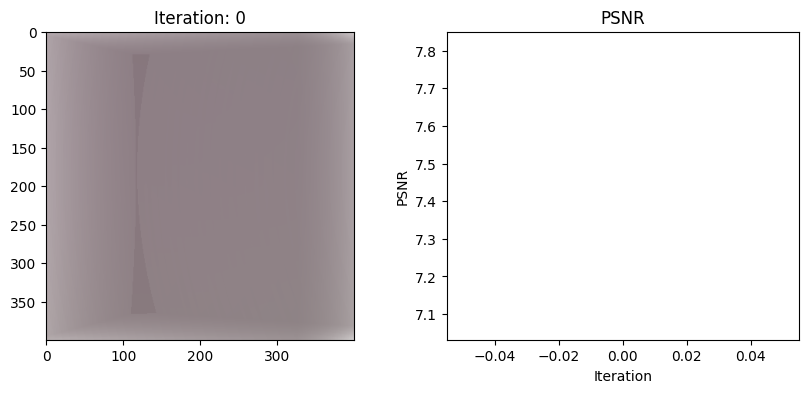

test


 10%|▉         | 139/1407 [00:25<04:27,  4.74it/s]

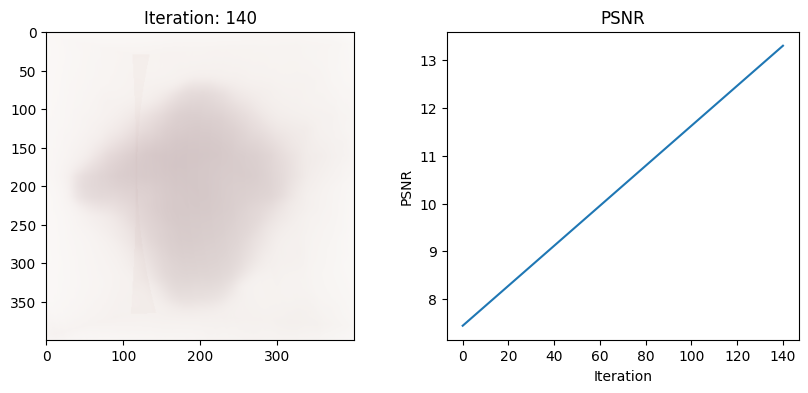

 20%|█▉        | 279/1407 [00:49<02:49,  6.66it/s]

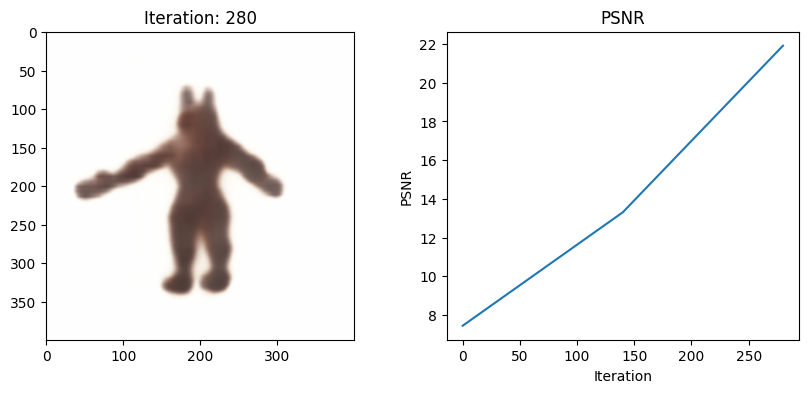

 30%|██▉       | 419/1407 [01:14<02:43,  6.03it/s]

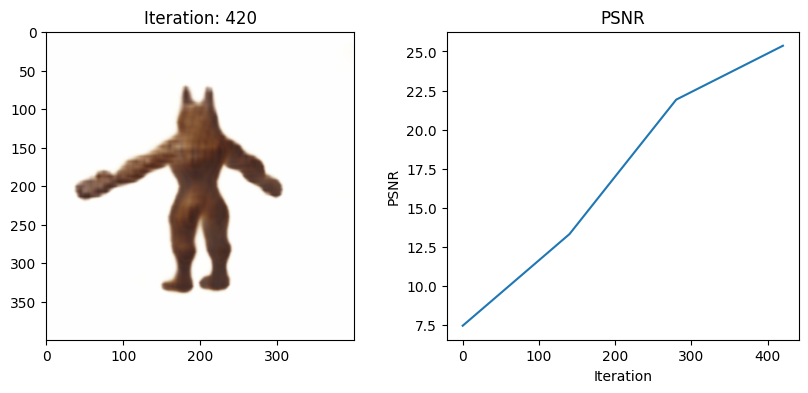

 40%|███▉      | 559/1407 [01:39<02:35,  5.47it/s]

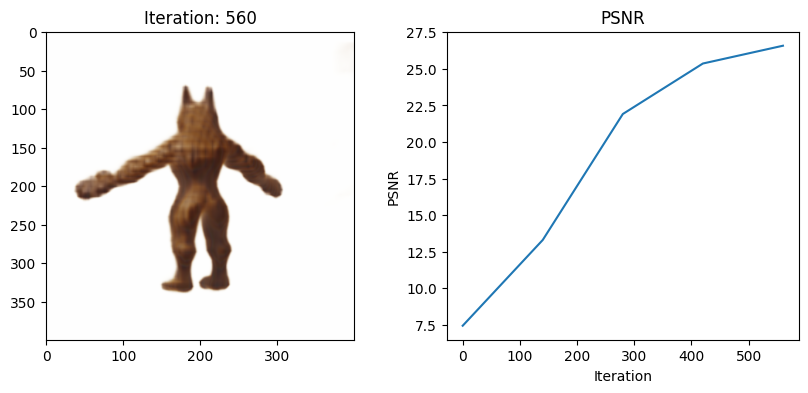

 50%|████▉     | 699/1407 [02:04<01:44,  6.80it/s]

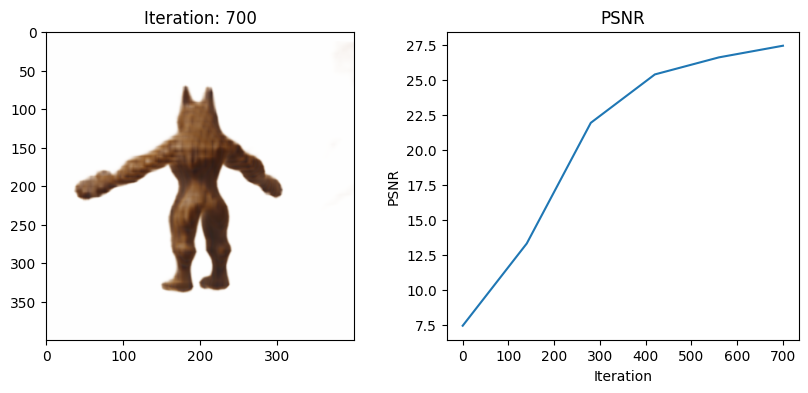

 60%|█████▉    | 839/1407 [02:28<01:41,  5.60it/s]

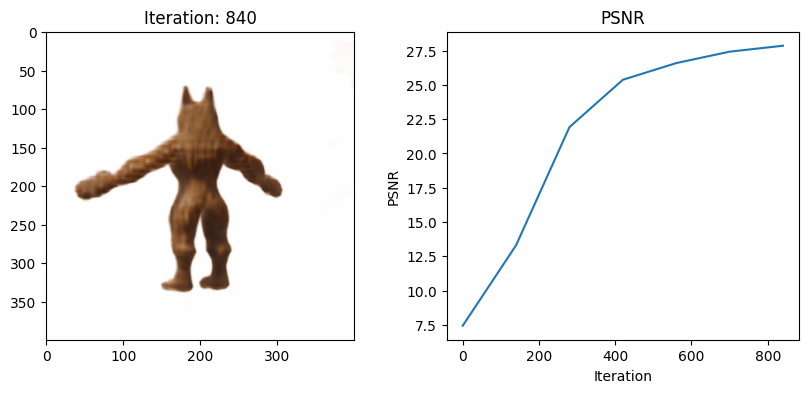

 70%|██████▉   | 979/1407 [02:53<01:02,  6.80it/s]

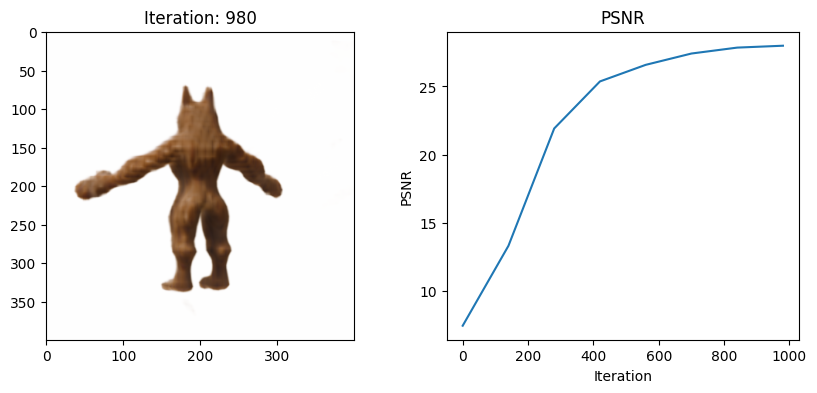

 80%|███████▉  | 1119/1407 [03:18<00:48,  5.92it/s]

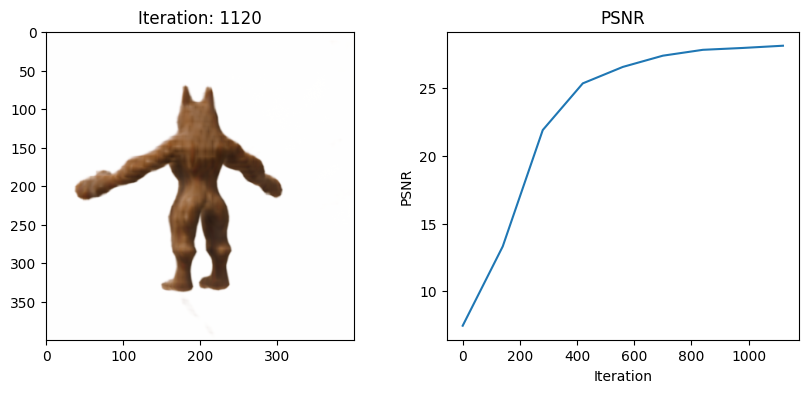

 89%|████████▉ | 1259/1407 [03:44<00:22,  6.70it/s]

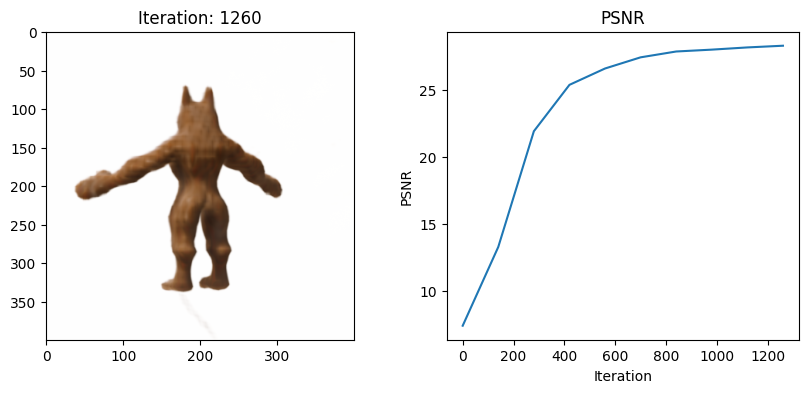

 99%|█████████▉| 1399/1407 [04:09<00:01,  5.84it/s]

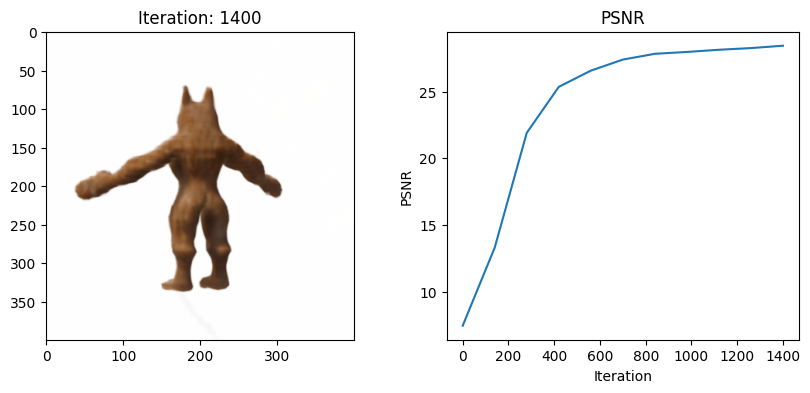

100%|██████████| 1407/1407 [04:13<00:00,  5.56it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


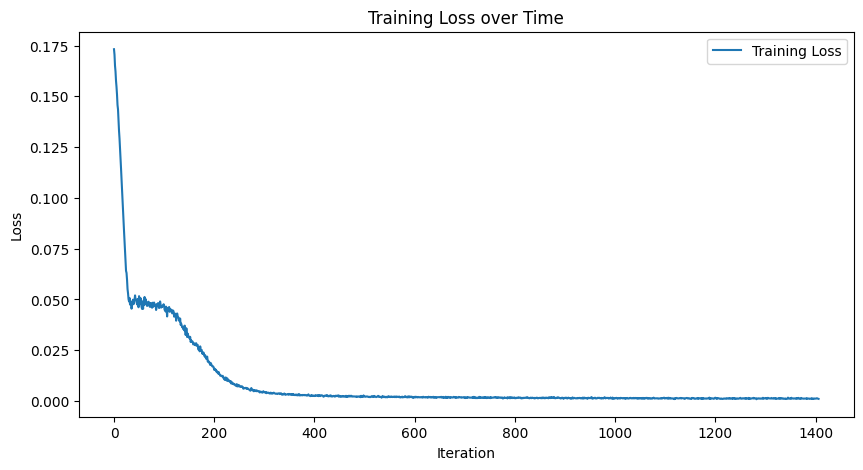

In [87]:
trainer.run()

In [89]:
eval(model , test_o[6] , test_d[6] , H=400, W=400 )

Video saved to novel_views360.mp4


In [90]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('novel_views360.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)